# Atmospheric Rivers: Filtering by Criteria

This notebook will import functions from the `ar_detection.py` module to expose the processing flow and to show a few examples.
Production runs could also be orchestrated from this notebook to leverage the use of an interactive Dask client if/when needed. Before executing this notebook be sure you've set your `AR_DATA_DIR` environment variable, and have executed both the `download.py` and `compute_ivt.py` scripts.

In [1]:
import random

import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm

from config import ar_params, ard_fp, shp_fp, csv_fp

# functions to create the binary "blobs" of IVT exceedance
from ar_detection import compute_intensity_mask, label_contiguous_mask_regions
# functions to measure the requisite blob properties
from ar_detection import generate_region_properties, get_data_for_ar_criteria, get_azimuth_of_furthest_points, get_directional_coherence, get_length_width_ratio, get_major_axis_haversine_distance, get_poleward_strength
# functions test whether or not criteria are met
from ar_detection import apply_criteria, filter_ars
# functions to generate vectorized output
from ar_detection import create_geodataframe_with_all_ars, create_shapefile

In [2]:
# inspect criteria, note that `window` and `ivt_percentile` are used in the IVT computation, not in the AR filtering done here
ar_params

{'window': 75,
 'ivt_percentile': 85,
 'ivt_floor': 100,
 'direction_deviation_threshold': 45,
 'mean_meridional': 50,
 'orientation_deviation_threshold': 45,
 'min_axis_length': 2000}

In [3]:
ivt_ds = xr.open_dataset(ard_fp)
ivt_ds.rio.write_crs("epsg:4326", inplace=True)
ivt_ds

<xarray.Dataset>
Dimensions:       (time: 43832, latitude: 225, longitude: 237)
Coordinates:
  * time          (time) datetime64[ns] 1992-01-01 ... 2021-12-31T18:00:00
  * longitude     (longitude) float32 -179.0 -178.8 -178.5 ... -120.2 -120.0
  * latitude      (latitude) float32 66.0 65.75 65.5 65.25 ... 10.5 10.25 10.0
    spatial_ref   int64 0
Data variables:
    p72.162       (time, latitude, longitude) float32 ...
    ivt_mag       (time, latitude, longitude) float32 ...
    ivt_dir       (time, latitude, longitude) float32 ...
    ivt_quantile  (time, latitude, longitude) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-08 18:05:11 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [4]:
%%time
ivt_ds["thresholded"] = compute_intensity_mask(ivt_ds["ivt_mag"], ivt_ds["ivt_quantile"], ar_params["ivt_floor"])

CPU times: user 16.5 s, sys: 14.5 s, total: 31 s
Wall time: 31 s


In [5]:
%%time
labeled_regions = label_contiguous_mask_regions(ivt_ds["thresholded"])

CPU times: user 1min 7s, sys: 2.98 s, total: 1min 10s
Wall time: 1min 10s


In [6]:
%%time
ar_di = generate_region_properties(labeled_regions, ivt_ds)

CPU times: user 6min 1s, sys: 43.5 s, total: 6min 44s
Wall time: 6min 45s


In [7]:
%%time
ar_di = get_data_for_ar_criteria(ar_di, ivt_ds)

Getting length/width ratio for each AR target::   0%|          | 7/43832 [00:00<10:59, 66.42it/s]

Getting axis length (km) for each AR target:: 100%|██████████| 43832/43832 [09:28<00:00, 77.12it/s] 
Getting overall orientation (azimuth) for each AR target:: 100%|██████████| 43832/43832 [07:31<00:00, 97.14it/s] 
Getting mean poleward strength for each AR target:: 100%|██████████| 43832/43832 [01:04<00:00, 682.70it/s] 
Getting directional coherence for each AR target:: 100%|██████████| 43832/43832 [02:35<00:00, 281.51it/s]
Getting total IVT strength for each AR target:: 100%|██████████| 43832/43832 [00:20<00:00, 2154.83it/s]
Getting relative IVT strength for each AR target:: 100%|██████████| 43832/43832 [00:21<00:00, 1994.59it/s]

CPU times: user 26min 11s, sys: 1min 8s, total: 27min 20s
Wall time: 27min 10s


In [8]:
%%time
ar_di = apply_criteria(ar_di)

  9%|▉         | 3876/43832 [00:00<00:02, 19174.82it/s]

100%|██████████| 43832/43832 [00:02<00:00, 17991.14it/s]

CPU times: user 2.3 s, sys: 157 ms, total: 2.45 s
Wall time: 2.44 s


In [10]:
# criteria exploration
# how many labeled regions meet the different numbers of criteria? 
# note that some criteria (overall orientation consistency) may oscillate between pass and fail depending on size of spatial domain


blob_count = 0

for b in ar_di:
    no_blobs = len(ar_di[b]["ar_targets"])
    blob_count = blob_count + no_blobs

print("TOTAL CANDIDATE ARs: " + str(blob_count))

crit_no = [1,2,3,4,5]
blob_crit = []

for c in crit_no:
    ars = filter_ars(ar_di, n_criteria_required=c)

    crit_count = 0

    for a in ars:
        ar_count = len(ars[a])
        crit_count = crit_count + ar_count
    
    blob_crit.append(crit_count)

for c, b in zip(crit_no, blob_crit):
    print("If requiring " + str(c) + " AR criteria, we find " + str(b) + " ARs...")

TOTAL CANDIDATE ARs: 549107


100%|██████████| 43832/43832 [00:00<00:00, 171251.74it/s]

If requiring 1 AR criteria, we find 549107 ARs...
If requiring 2 AR criteria, we find 527427 ARs...
If requiring 3 AR criteria, we find 354711 ARs...
If requiring 4 AR criteria, we find 129353 ARs...
If requiring 5 AR criteria, we find 23733 ARs...


In [11]:
%%time
# default criteria is the maximum (5)
output_ars = filter_ars(ar_di, n_criteria_required=5)

 29%|██▉       | 12914/43832 [00:00<00:00, 129129.66it/s]

100%|██████████| 43832/43832 [00:00<00:00, 134414.97it/s]

CPU times: user 329 ms, sys: 8.88 ms, total: 338 ms
Wall time: 333 ms


Text(0.5, 1.0, 'AR candidate blobs')

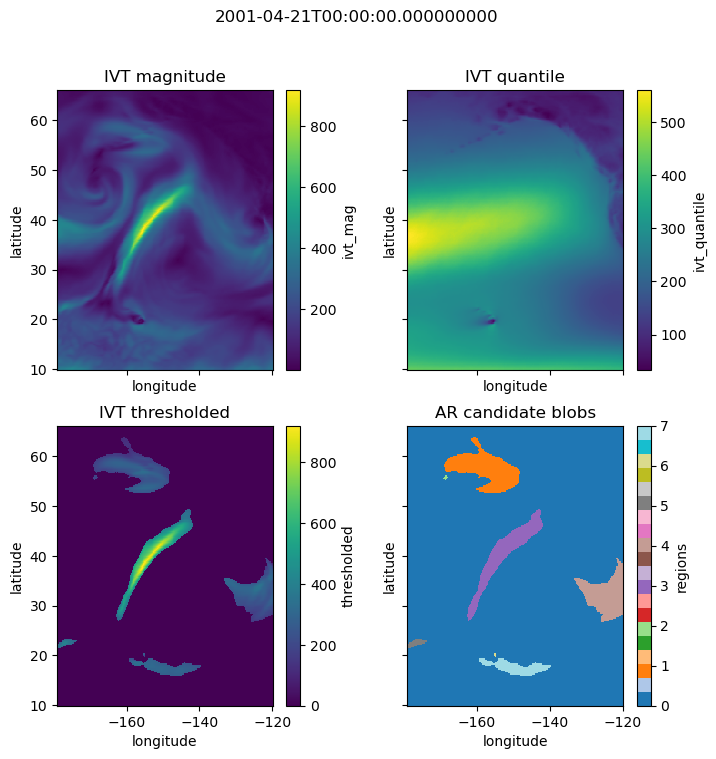

In [12]:
#plot a random timestep from the filtered ARs

random_date = random.choice(list(output_ars.keys()))
fig, axes = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(8,8))
plt.subplots_adjust(wspace=0.3)
plt.suptitle(random_date)

ivt_ds["ivt_mag"].sel(time=random_date).plot(ax=axes[0,0])
ivt_ds["ivt_quantile"].sel(time=random_date).plot(ax=axes[0,1])
ivt_ds["thresholded"].sel(time=random_date).plot(ax=axes[1,0])
labeled_regions.sel(time=random_date).plot(ax=axes[1,1], cmap="tab20")

axes[0,0].set_title("IVT magnitude")
axes[0,1].set_title("IVT quantile")

axes[1,0].set_title("IVT thresholded")
axes[1,1].set_title("AR candidate blobs")

In [12]:
%%time
#create a master geodataframe of filtered ARs
gdf = create_geodataframe_with_all_ars(output_ars, ar_di, labeled_regions, ivt_ds)

100%|██████████| 21234/21234 [07:56<00:00, 44.53it/s]


CPU times: user 7min 16s, sys: 22.7 s, total: 7min 38s
Wall time: 8min 8s


In [15]:
gdf.columns

Index(['time', 'label', 'geometry', 'ratio', 'length', 'orient', 'poleward',
       'dir_coher', 'mean_dir', 'crit1', 'crit2', 'crit3', 'crit4', 'crit5',
       'crit_cnt'],
      dtype='object')

In [16]:
from ar_detection import create_geodataframe_with_all_ars, create_shapefile
#export as shapefile with crosswalk csv for column names
create_shapefile(gdf, shp_fp, csv_fp)

In [17]:
gdf.columns

Index(['time', 'label', 'geometry', 'ratio', 'length', 'orient', 'poleward',
       'dir_coher', 'mean_dir', 'crit1', 'crit2', 'crit3', 'crit4', 'crit5',
       'crit_cnt'],
      dtype='object')

In [15]:
ivt_ds.close()

,time,label,geometry,ratio,length,orient,poleward,dir_coher,mean_dir,crit1,crit2,crit3,crit4,crit5,crit_cnt
22783,2020-12-01T00:00:00.000000000,2.0,"POLYGON ((-149.62500 61.62500, -149.62500 61.3...",2.8,4258,25,240,79,359,True,True,True,True,True,5


<Axes: >

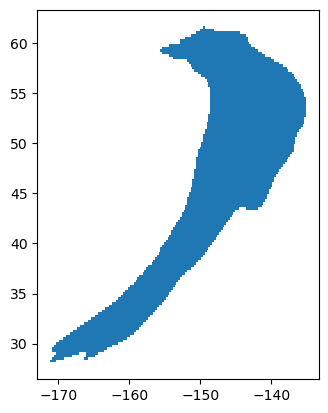

In [18]:
#checking out the Haines 2020 AR event....the region property values seems reasonable when compared to the image! 
display(gdf.loc[gdf['time']=='2020-12-01T00:00:00.000000000'])
gdf.loc[gdf['time']=='2020-12-01T00:00:00.000000000', 'geometry'].plot()